TF: 2.20.0
GPU: CPU only
Data: dataset\daily_HKO_GMT_ALL.csv

📄 Raw data preview (first 5 rows):
                                                Year    Month    Day  \
0                                   日平均草溫(攝氏度) - 天文台      NaN    NaN   
1  Daily Grass Minimun Temperature (°C) at the Ho...      NaN    NaN   
2                                             年/Year  月/Month  日/Day   
3                                               1968        1      1   
4                                               1968        1      2   

       temp                     Flag  
0       NaN                      NaN  
1       NaN                      NaN  
2  數值/Value  數據完整性/data Completeness  
3       4.2                        C  
4       7.7                        C  

✅ After cleaning:
            temp
Date            
1968-01-01   4.2
1968-01-02   7.7
1968-01-03   5.3
1968-01-04   6.5
1968-01-05  11.7
1968-01-06  14.4
1968-01-07  15.2
1968-01-08  11.7
1968-01-09  11.3
1968-01-10   9.1

📈 Full range

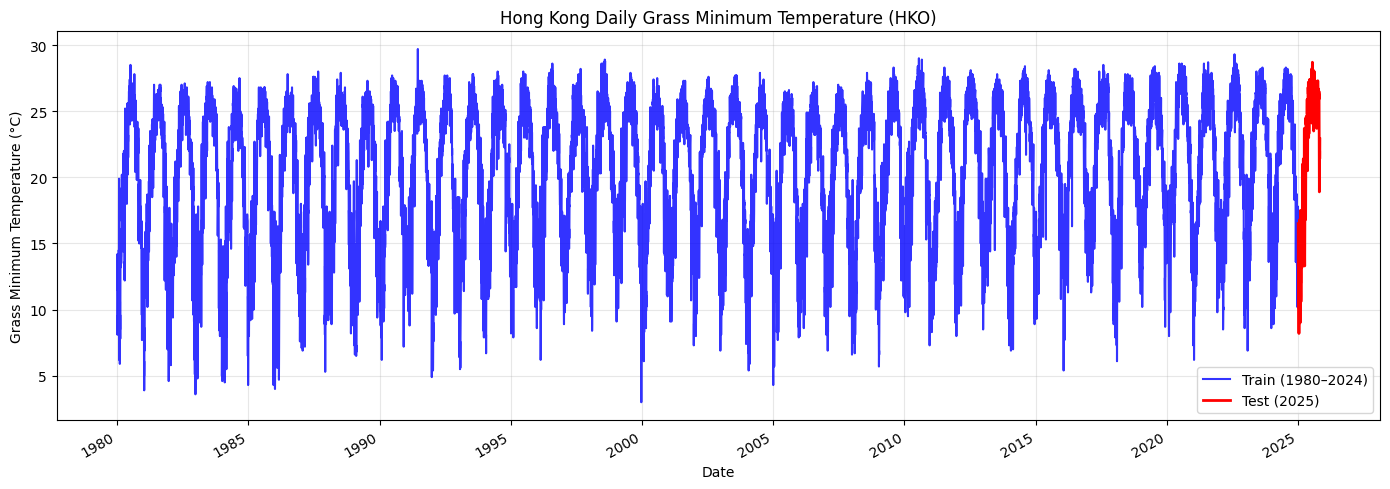


=== TRAINING RNN ===
Epoch 1/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0620 - val_loss: 0.0029
Epoch 2/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 11/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 12/100
459/45

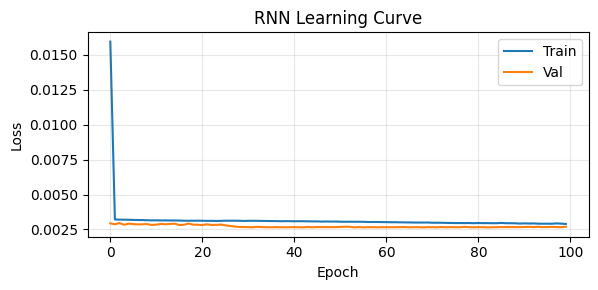


=== TRAINING LSTM ===
Epoch 1/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0357 - val_loss: 0.0056
Epoch 2/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0085 - val_loss: 0.0047
Epoch 3/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 4/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 5/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 6/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 7/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 8/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 9/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 11/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 1

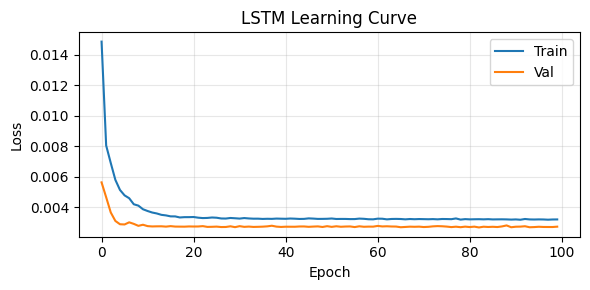


=== TRAINING BiLSTM ===
Epoch 1/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0284 - val_loss: 0.0052
Epoch 2/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 3/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 4/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 5/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 6/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 7/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 8/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 9/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 11/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch

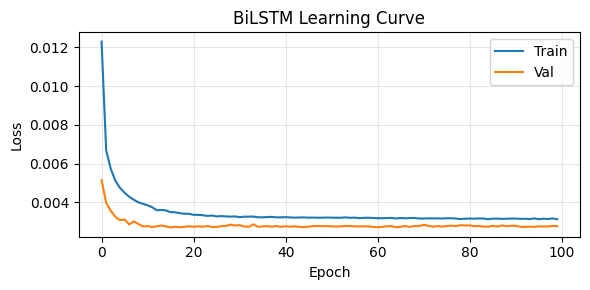

In [23]:
# -------------------------------------------------
# CELL 0: Imports and Config
# -------------------------------------------------
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
tf.random.set_seed(42); np.random.seed(42)

print("TF:", tf.__version__)
print("GPU:", "Available" if tf.config.list_physical_devices('GPU') else "CPU only")

# -------------------------------------------------
# CELL 1: Paths and Constants
# -------------------------------------------------
DATA_FILE = Path(r"dataset\daily_HKO_GMT_ALL.csv")
NOTEBOOK_ROOT = Path(r"D:\Study\Project_Database\DIT5411-ProjectAssignment")
SEQ_LEN = 30
EPOCHS = 100
BATCH_SIZE = 32

DATA_FILE.parent.mkdir(parents=True, exist_ok=True)
NOTEBOOK_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Data: {DATA_FILE}")

# -------------------------------------------------
# CELL 2: Load & Preprocess Data
# -------------------------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(
        file_path,
        header=None,
        names=['Year', 'Month', 'Day', 'temp', 'Flag'],
        na_values=["---"],
        skipinitialspace=True
    )

    print("\n📄 Raw data preview (first 5 rows):")
    print(df.head())

    # Create Date column
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

    # Drop invalid dates
    df = df.dropna(subset=['Date'])

    # Keep only Date and temp
    df = df[['Date', 'temp']].set_index('Date').sort_index()

    # Clean temperature column
    df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
    df = df.dropna(subset=['temp'])  # drop NaNs
    df = df[~df.index.duplicated(keep='first')]  # remove duplicates

    print("\n✅ After cleaning:")
    print(df.head(10))  # show first few cleaned entries

    # Split to train/test
    train_df = df['1980-01-01':'2024-12-31']
    test_df = df['2025-01-01':'2025-10-30']

    train_df = train_df.interpolate().ffill().bfill()
    test_df = test_df.interpolate().ffill().bfill()

    print(f"\n📈 Full range: {df.index.min().date()} → {df.index.max().date()}")
    print(f"Train: {len(train_df)} days | Test: {len(test_df)} days")
    print(f"Temp range: {train_df['temp'].min():.1f}°C to {train_df['temp'].max():.1f}°C")

    return train_df, test_df

train_df, test_df = load_and_preprocess(DATA_FILE)

# Plot raw data
plt.figure(figsize=(14, 5))
train_df['temp'].plot(label='Train (1980–2024)', color='blue', alpha=0.8)
test_df['temp'].plot(label='Test (2025)', color='red', linewidth=2)
plt.ylabel('Grass Minimum Temperature (°C)')
plt.title('Hong Kong Daily Grass Minimum Temperature (HKO)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(NOTEBOOK_ROOT / 'raw_data.png', dpi=200)
plt.show()

# -------------------------------------------------
# CELL 3: Sequence Creation
# -------------------------------------------------
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# -------------------------------------------------
# CELL 4: Model Builders
# -------------------------------------------------
def build_rnn(seq_len, n_features=1):
    model = models.Sequential([
        layers.SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_len, n_features)),
        layers.SimpleRNN(50, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(seq_len, n_features=1, bidirectional=False):
    model = models.Sequential()
    if bidirectional:
        model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True), input_shape=(seq_len, n_features)))
        model.add(layers.Bidirectional(layers.LSTM(50)))
    else:
        model.add(layers.LSTM(50, return_sequences=True, input_shape=(seq_len, n_features)))
        model.add(layers.LSTM(50))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# -------------------------------------------------
# CELL 5: Train Models
# -------------------------------------------------
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

results = {}
models_dict = {}

for name, build_fn in [('RNN', build_rnn), ('LSTM', build_lstm)]:
    print(f"\n=== TRAINING {name} ===")
    model = build_fn(SEQ_LEN)
    callbacks = [
        ModelCheckpoint(NOTEBOOK_ROOT / f'{name}_best.keras', save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks
    )
    models_dict[name] = model
    results[name] = {
        'best_epoch': np.argmin(history.history['val_loss']) + 1,
        'min_val_loss': min(history.history['val_loss'])
    }
    plot_learning_curve(history, name)

# Train BiLSTM without EarlyStopping
print("\n=== TRAINING BiLSTM ===")
bidir_model = build_lstm(SEQ_LEN, bidirectional=True)
bidir_history = bidir_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    callbacks=[
        ModelCheckpoint(NOTEBOOK_ROOT / 'BiLSTM_best.keras', save_best_only=True, monitor='val_loss')
    ]
)
models_dict['BiLSTM'] = bidir_model
results['BiLSTM'] = {
    'best_epoch': np.argmin(bidir_history.history['val_loss']) + 1,
    'min_val_loss': min(bidir_history.history['val_loss'])
}
plot_learning_curve(bidir_history, 'BiLSTM')

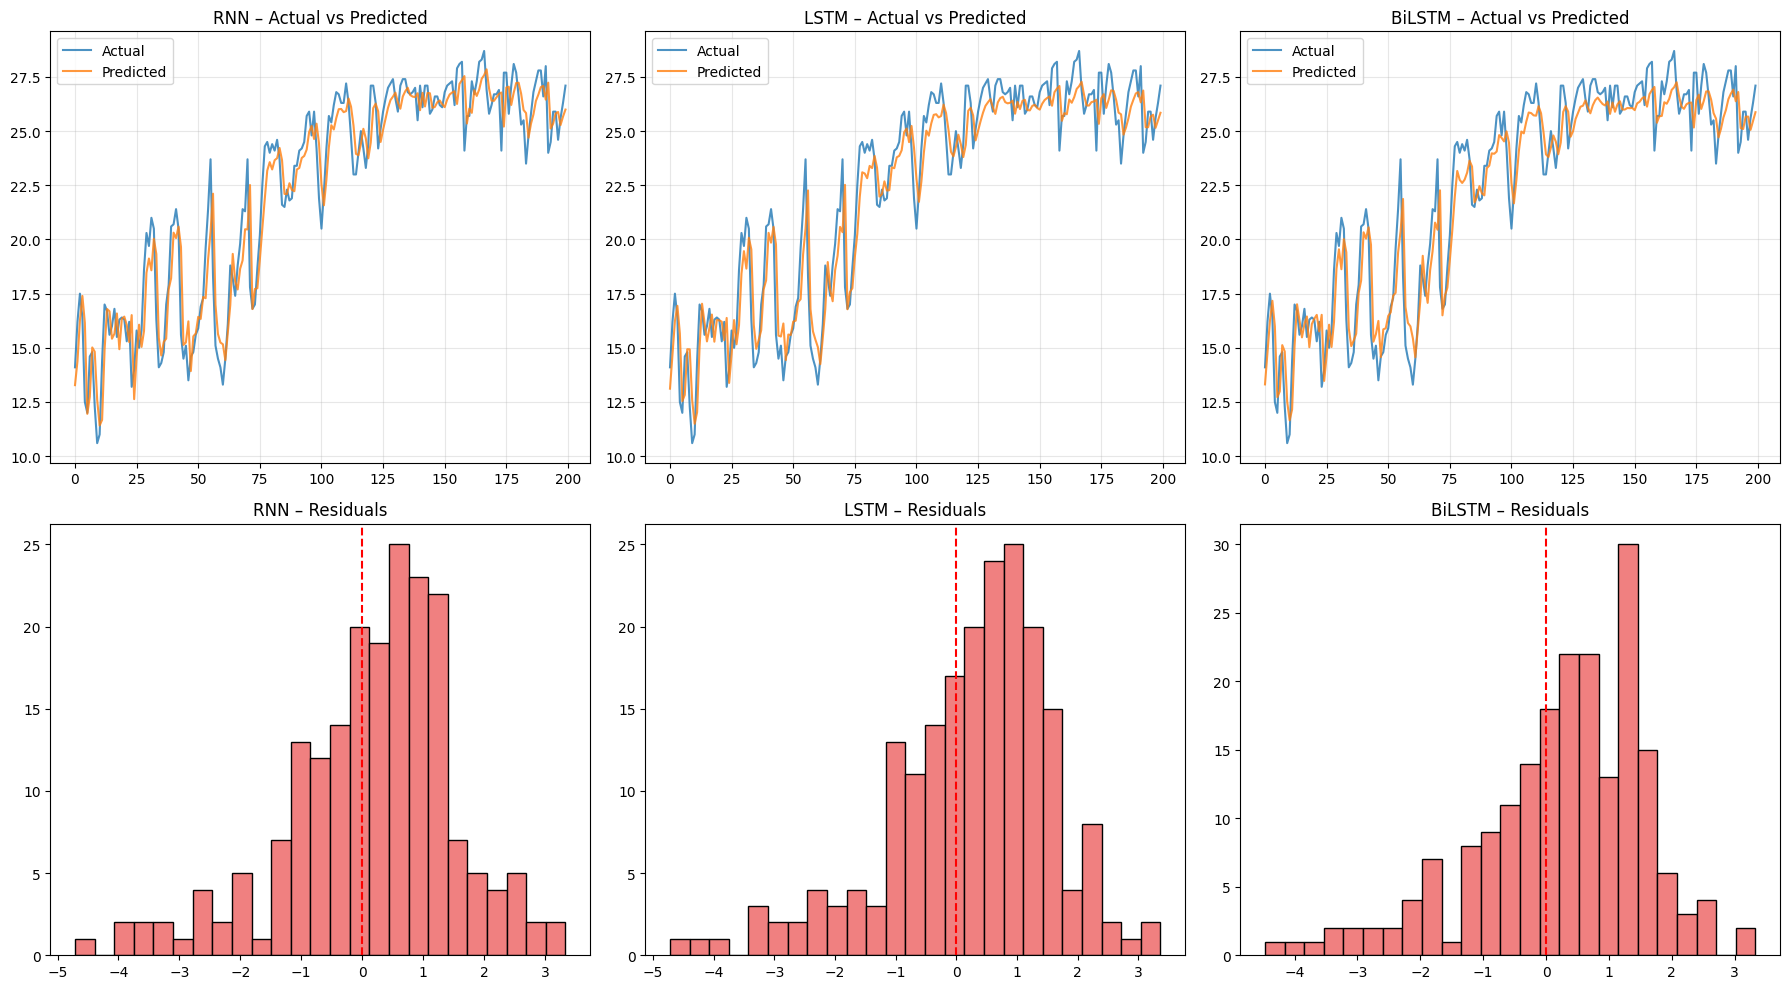

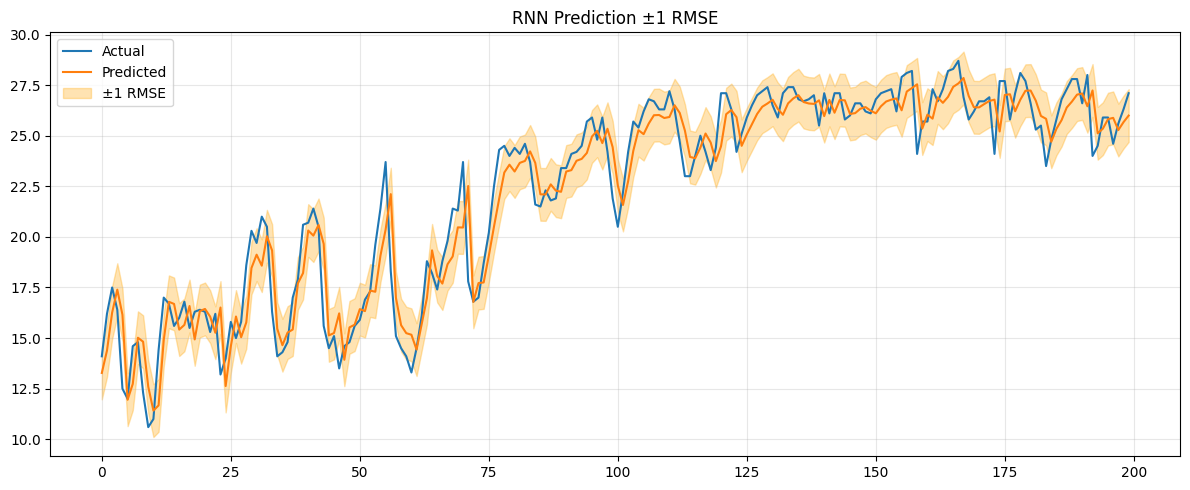

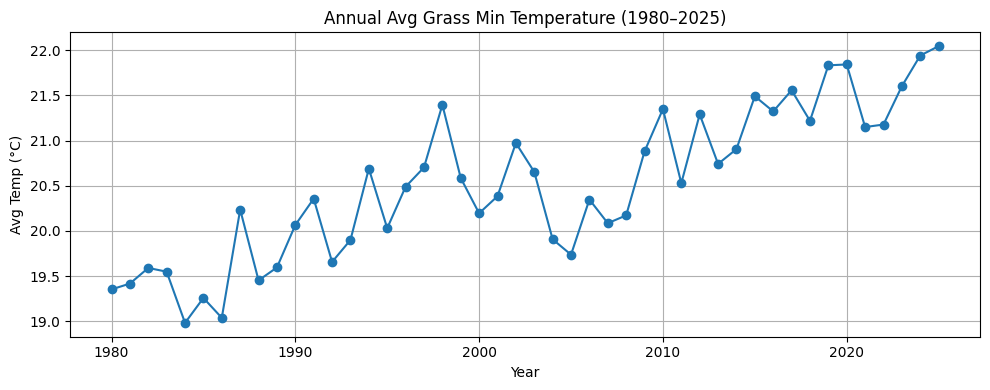


📊 Final Model Comparison:
          MAE   RMSE
RNN     0.972  1.304
LSTM    1.008  1.319
BiLSTM  1.017  1.316

Min: 10.6
Max: 28.7

⚠️ No days found with temperature < 5.0°C.

⚠️ No days found with temperature > 30.0°C.

🌨️ Winter MAE (Dec–Feb): 1.264°C

☀️ Summer MAE (Jun–Aug): 0.796°C

📅 Monthly MAE Breakdown:
  Jan: 0.823°C
  Feb: 1.280°C
  Mar: 1.429°C
  Apr: 1.218°C
  May: 0.986°C
  Jun: 0.709°C
  Jul: 0.952°C
  Aug: 0.730°C
  Sep: 0.696°C
  Oct: 0.775°C

🌡️ MAE by Temperature Band:
  ❄️ Cold (<5°C): No data
  🌤️ Moderate (5–25°C): 1.318°C
  🔥 Hot (>25°C): 0.636°C


In [24]:
# -------------------------------------------------
# CELL 6: Evaluation
# -------------------------------------------------
def evaluate_model(model, X_test, y_test, scaler):
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return y_true, y_pred, mae, rmse

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, name in enumerate(results):
    model = models_dict[name]
    y_true, y_pred, mae, rmse = evaluate_model(model, X_test, y_test, scaler)
    results[name]['MAE'] = mae
    results[name]['RMSE'] = rmse

    axes[i].plot(y_true[:200], label='Actual', alpha=0.8)
    axes[i].plot(y_pred[:200], label='Predicted', alpha=0.8)
    axes[i].set_title(f'{name} – Actual vs Predicted')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

    residuals = y_true[:200] - y_pred[:200]
    axes[i+3].hist(residuals, bins=25, color='lightcoral', edgecolor='black')
    axes[i+3].axvline(0, color='red', linestyle='--')
    axes[i+3].set_title(f'{name} – Residuals')

plt.tight_layout()
plt.savefig(NOTEBOOK_ROOT / 'predictions_comparison.png', dpi=200)
plt.show()

# -------------------------------------------------
# CELL 7: Final Analysis
# -------------------------------------------------
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = models_dict[best_model_name]
y_true_full, y_pred_full, _, rmse = evaluate_model(best_model, X_test, y_test, scaler)

# Plot with uncertainty
def plot_prediction_with_uncertainty(y_true, y_pred, model_name, rmse):
    lower = y_pred - rmse
    upper = y_pred + rmse
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:200], label='Actual')
    plt.plot(y_pred[:200], label='Predicted')
    plt.fill_between(range(200), lower[:200, 0], upper[:200, 0], color='orange', alpha=0.3, label='±1 RMSE')
    plt.title(f'{model_name} Prediction ±1 RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_prediction_with_uncertainty(y_true_full, y_pred_full, best_model_name, rmse)

# -------------------------------------------------
# CELL 8: Annual Climate Trend
# -------------------------------------------------
def plot_annual_trend(df):
    annual_avg = df['temp'].resample('Y').mean()
    plt.figure(figsize=(10, 4))
    plt.plot(annual_avg.index.year, annual_avg.values, marker='o')
    plt.title("Annual Avg Grass Min Temperature (1980–2025)")
    plt.xlabel("Year")
    plt.ylabel("Avg Temp (°C)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_annual_trend(pd.concat([train_df, test_df]))

# -------------------------------------------------
# CELL 9: Export Results
# -------------------------------------------------
comparison_df = pd.DataFrame(results).T[['MAE', 'RMSE']].round(3)
comparison_df = comparison_df.sort_values('MAE')
print("\n📊 Final Model Comparison:")
print(comparison_df)

# Save to markdown
comparison_df.reset_index().rename(columns={'index': 'Model'}).to_markdown(NOTEBOOK_ROOT / 'model_results.md')

# -------------------------------------------------
# CELL 10: Model Condition Testing (Cold, Hot, Seasonal, Monthly)
# -------------------------------------------------

# Cold Days Test
def analyze_extreme_cold_days(y_true, y_pred, threshold=5.0):
    mask = y_true.flatten() < threshold
    if np.sum(mask) == 0:
        print(f"\n⚠️ No days found with temperature < {threshold}°C.")
        return
    extreme_mae = mean_absolute_error(y_true[mask], y_pred[mask])
    print(f"\n❄️ MAE on cold days (<{threshold}°C): {extreme_mae:.3f}°C")

# Hot Days Test
def analyze_extreme_hot_days(y_true, y_pred, threshold=30.0):
    mask = y_true.flatten() > threshold
    if np.sum(mask) == 0:
        print(f"\n⚠️ No days found with temperature > {threshold}°C.")
        return
    hot_mae = mean_absolute_error(y_true[mask], y_pred[mask])
    print(f"\n🔥 MAE on hot days (>{threshold}°C): {hot_mae:.3f}°C")

# Winter Months Test (Dec–Feb)
def analyze_winter_performance(y_true, y_pred, test_index, seq_len):
    winter_mask = test_index.month.isin([12, 1, 2])[seq_len:]
    winter_true = y_true[winter_mask]
    winter_pred = y_pred[winter_mask]
    if len(winter_true) == 0:
        print("\n⚠️ No winter months found in test data.")
        return
    winter_mae = mean_absolute_error(winter_true, winter_pred)
    print(f"\n🌨️ Winter MAE (Dec–Feb): {winter_mae:.3f}°C")

# Summer Months Test (Jun–Aug)
def analyze_summer_performance(y_true, y_pred, test_index, seq_len):
    summer_mask = test_index.month.isin([6, 7, 8])[seq_len:]
    summer_true = y_true[summer_mask]
    summer_pred = y_pred[summer_mask]
    if len(summer_true) == 0:
        print("\n⚠️ No summer months found in test data.")
        return
    summer_mae = mean_absolute_error(summer_true, summer_pred)
    print(f"\n☀️ Summer MAE (Jun–Aug): {summer_mae:.3f}°C")

# MAE by Month
def analyze_monthly_mae(y_true, y_pred, test_index, seq_len):
    print("\n📅 Monthly MAE Breakdown:")
    months = range(1, 13)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_indices = test_index.month[seq_len:]
    for i, name in zip(months, month_names):
        mask = month_indices == i
        if np.sum(mask) == 0:
            continue
        month_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        print(f"  {name}: {month_mae:.3f}°C")

# MAE by Temperature Band
def analyze_temp_band_mae(y_true, y_pred):
    y_flat = y_true.flatten()
    bands = {
        "❄️ Cold (<5°C)": y_flat < 5,
        "🌤️ Moderate (5–25°C)": (y_flat >= 5) & (y_flat <= 25),
        "🔥 Hot (>25°C)": y_flat > 25
    }

    print("\n🌡️ MAE by Temperature Band:")
    for label, mask in bands.items():
        if np.sum(mask) == 0:
            print(f"  {label}: No data")
            continue
        band_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        print(f"  {label}: {band_mae:.3f}°C")

# -------------------------------------------------
# ✅ Run All Tests
# -------------------------------------------------
print("\nMin:", y_true_full.min())
print("Max:", y_true_full.max())
analyze_extreme_cold_days(y_true_full, y_pred_full)
analyze_extreme_hot_days(y_true_full, y_pred_full)
analyze_winter_performance(y_true_full, y_pred_full, test_df.index, SEQ_LEN)
analyze_summer_performance(y_true_full, y_pred_full, test_df.index, SEQ_LEN)
analyze_monthly_mae(y_true_full, y_pred_full, test_df.index, SEQ_LEN)
analyze_temp_band_mae(y_true_full, y_pred_full)